# Install*

# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Wed Jun 16 10:13:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir

data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)
# ner_dir = os.path.join(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair',
 'songys-chat',
 'kornli',
 'kornli.model',
 'kornli.vocab',
 'xnli.dev.ko.tsv',
 'xnli.test.ko.tsv',
 'multinli.train.ko.tsv',
 'snli_1.0_train.ko.tsv',
 'ner']

In [ ]:
ner_dir = os.path.join(data_dir, "ner") # 폴더를 ner로 만들게
if not os.path.isdir(ner_dir):
    os.makedirs(ner_dir)
os.listdir(ner_dir)

['ner.csv_modi', 'vocab_pos.txt', 'vocab_word.txt', 'vocab_tag.txt']

# Data*

In [ ]:
!git clone https://github.com/kmounlp/NER.git

Cloning into 'NER'...
remote: Enumerating objects: 1770, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1770 (delta 0), reused 42 (delta 0), pack-reused 1727
Receiving objects: 100% (1770/1770), 20.69 MiB | 24.47 MiB/s, done.
Resolving deltas: 100% (146/146), done.


# Morph*

In [ ]:
!ls

drive  NER  sample_data


In [ ]:
files = os.listdir('/content/NER/말뭉치 - 형태소_개체명') # 경로복사해주고
files


['20255_NER.txt',
 '32507_NER.txt',
 '10020_NER.txt',
 '00236_NER.txt',
 '32608_NER.txt',
 '10223_NER.txt',
 '10232_NER.txt',
 '00026_NER.txt',
 '00002_NER.txt',
 '00083_NER.txt',
 '32746_NER.txt',
 '00850_NER.txt',
 '10242_NER.txt',
 '32595_NER.txt',
 '32535_NER.txt',
 '00825_NER.txt',
 '00268_NER.txt',
 '00805_NER.txt',
 '00791_NER.txt',
 '00076_NER.txt',
 '20165_NER.txt',
 '20082_NER.txt',
 '32622_NER.txt',
 '00743_NER.txt',
 '00124_NER.txt',
 '00041_NER.txt',
 '00202_NER.txt',
 '20071_NER.txt',
 '20030_NER.txt',
 '10215_NER.txt',
 '00792_NER.txt',
 '00687_NER.txt',
 '00093_NER.txt',
 '00046_NER.txt',
 '32545_NER.txt',
 '10098_NER.txt',
 '00677_NER.txt',
 '10071_NER.txt',
 '10136_NER.txt',
 '00172_NER.txt',
 '10086_NER.txt',
 '00809_NER.txt',
 '32707_NER.txt',
 '32541_NER.txt',
 '00084_NER.txt',
 '00613_NER.txt',
 '00156_NER.txt',
 '20117_NER.txt',
 '32601_NER.txt',
 '00031_NER.txt',
 '32665_NER.txt',
 '10244_NER.txt',
 '00619_NER.txt',
 '00813_NER.txt',
 '10238_NER.txt',
 '10143_NE

In [ ]:
# files = os.listdir('/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/ner') # 경로복사해주고
# files


In [ ]:
with open(os.path.join('/content/NER/말뭉치 - 형태소_개체명', files[0])) as f:
    for i ,line in enumerate(f):
        line = line.strip() #strip안하면 개행문자가 되니까 2줄이 되지
        print(line)
        if i > 100:
             break

#음 앞에 ## 을 잘 처리해보자

## 1
## 그는 자신과 함께 ‘박 남매’로 불렸던 더불어민주당 박영선 의원을 예로 들며 “앵커 출신이라 전달력이 좋다”며 “박 의원이 야성(野性)에다 미모를 갖춰 법제사법위원회에서 항상 히트를 쳤다.
## 그는 자신과 함께 ‘<박:PER> 남매’로 불렸던 <더불어민주당:ORG> <박영선:PER> 의원을 예로 들며 “앵커 출신이라 전달력이 좋다”며 “<박:PER> 의원이 야성(野性)에다 미모를 갖춰 <법제사법위원회:ORG>에서 항상 히트를 쳤다.
그	그	NP	O
는	는	JX	O
_	_	_	O
자신	자신	NNG	O
과	과	JKB	O
_	_	_	O
함께	함께	MAG	O
_	_	_	O
‘	‘	SS	O
박	박	NNP	B-PER
_	_	_	O
남매	남매	NNG	O
’	’	SS	O
로	로	JKB	O
_	_	_	O
불	불리	VV	O
렸	었	EP	O
던	던	ETM	O
_	_	_	O
더불	더불	VV	B-ORG
어	어	EC	I-ORG
민주당	민주당	NNP	I-ORG
_	_	_	O
박영선	박영선	NNP	B-PER
_	_	_	O
의원	의원	NNG	O
을	을	JKO	O
_	_	_	O
예	예	NNG	O
로	로	JKB	O
_	_	_	O
들	들	VV	O
며	며	EC	O
_	_	_	O
“	“	SS	O
앵커	앵커	NNG	O
_	_	_	O
출신	출신	NNG	O
이	이	VCP	O
라	라	EC	O
_	_	_	O
전달	전달	NNG	O
력	력	XSN	O
이	이	JKS	O
_	_	_	O
좋	좋	VA	O
다	다	EF	O
”	”	SS	O
며	며	EC	O
_	_	_	O
“	“	SS	O
박	박	NNP	B-PER
_	_	_	O
의원	의원	NNG	O
이	이	JKS	O
_	_	_	O
야성	야성	NNG	O
(	(	SS	O
野性	野性	SH	O
)	)	SS	O
에다	에다	JKB	O
_	_	_	O
미모	미모	NNG	O
를	를	JKO	O
_	_	_	O
갖춰	갖추+어	VV+EC	O
_	_	_	O
법제	법제	NNG	B-ORG
사법	사법	NNG	I-ORG
위원회	위원회	NNG	I-ORG
에서	에서	JKB	O
_	_	_	O
항상

In [ ]:
def get_raw_data(filepath):
    texts, labels = [], []
    with open(filepath) as f:
        sharp_count = 0
        # text, label = '',''
        for line in f:
            line = line.strip()
            # print(line)
            if line.startswith('##'):
                sharp_count += 1
                # print(sharp_count,line)
                if sharp_count == 1:
                    pass
                elif sharp_count ==2:
                    text = ' '.join(line[3:].split()) # 띄어쓰기가 2,3개 이상으로 오타날수 잇잖아
                elif sharp_count == 3:
                    label = ' '.join(line[3:].split()) # 띄어쓰기가 2,3개 이상으로 오타날수 잇잖아
                    texts.append(text)
                    labels.append(label)
                    # print(text)
                    # print(label)
            else:
                sharp_count = 0
                text, label = '',''
            # print(sharp_count, line)
                
    return texts, labels

In [ ]:
get_raw_data(os.path.join('/content/NER/말뭉치 - 형태소_개체명', files[1]))

(['루비오에 대해서도 “왜 (폭스뉴스 같은) 주류 언론이 루비오 같은 친구가 승리했다고 치켜세우는지 모르겠다.',
  '미셸 위는 지난 2014년 메이저 대회인 US여자오픈을 비롯해 시즌 2승을 거두며 최고의 해를 보냈다.',
  '‘힐스테이트 태전’은 지하 3층, 지상 최고 23층 40개 동 전용면적 59∼84m² 총 3146채로 이뤄졌다.',
  '25.7㎡(약 7.8평) 크기인 김씨의 새집은 추석 전인 오는 20일 완공될 예정이다.',
  '장타를 앞세워 많은 타수를 줄이는 박성현의 화끈한 공격골프를 가장 잘 보여주는 대목이기도 하다.',
  '그러나콘래드 힐튼의 변호인 측은 "수면제로 인한 폭력적 성향의 부작용"이라고 적극 해명했다.',
  '이번 행사는 오는 7일까지 진행된다.',
  '목타는 가뭄과 폭염이 계속되는 가운데 제7호 태풍 「월트」가 22일 진로를 바꾸어 한반도를 향해 접근하고 있다.'],
 ['<루비오:PER>에 대해서도 “왜 (<폭스뉴스:ORG> 같은) 주류 언론이 <루비오:PER> 같은 친구가 승리했다고 치켜세우는지 모르겠다.',
  '<미셸 위:PER>는 지난 <2014년:DAT> 메이저 대회인 <US여자오픈:POH>을 비롯해 시즌 <2승:NOH>을 거두며 최고의 해를 보냈다.',
  '‘<힐스테이트 태전:LOC>’은 지하 <3층:NOH>, 지상 최고 <23층:NOH> <40개:NOH> 동 전용면적 <59:NOH>∼<84m²:NOH> 총 <3146채:NOH>로 이뤄졌다.',
  '<25.7㎡:NOH>(약 <7.8평:NOH>) 크기인 <김:PER>씨의 새집은 <추석:DAT> 전인 오는 <20일:DAT> 완공될 예정이다.',
  '장타를 앞세워 많은 타수를 줄이는 <박성현:PER>의 화끈한 공격골프를 가장 잘 보<여주:LOC>는 대목이기도 하다.',
  '그러나<콘래드 힐튼:PER>의 변호인 측은 "수면제로 인한 폭력적 성향의 부작용"이라고 적극 해명했다.',
  '이번 행사는 오는 <7일:DAT>까지 진행된다.',
  '목타는 가뭄

In [ ]:
all_texts, all_labels = [],[]
for each_file in files:
    texts, labels = get_raw_data(os.path.join('/content/NER/말뭉치 - 형태소_개체명', each_file))
    all_texts.extend(texts)
    all_labels.extend(labels) 

# append => [] append [1,2,3] append [4,5,6] => [[1,2,3],[4,5,6]]
# expand => [] extend [1,2,3] extend [4,5,6] => [1,2,3,4,5,6]

# for 문을 돌리려면 expand로 집어넣어야 하나씩 나오지  append로 돌리면 더미로 나온다


In [ ]:
data = {'text' : all_texts, 'label' : all_labels}
# data['text']
# df = pd.pandas(columns = [input, label])
df = pd.DataFrame(data)
df

,text,label
0,그는 자신과 함께 ‘박 남매’로 불렸던 더불어민주당 박영선 의원을 예로 들며 “앵커...,그는 자신과 함께 ‘<박:PER> 남매’로 불렸던 <더불어민주당:ORG> <박영선:...
1,"링컨은 이날 경쟁차로 메르세데스-벤츠 S클래스, BMW 7시리즈 같은 대형 세단을 ...","<링컨:PER>은 이날 경쟁차로 <메르세데스-벤츠:ORG> <S클래스:POH>, <..."
2,앞으로 3년안엔 유인점포(현재 3백50여개)보다 더 많은 무인점포망을 갖춘다는게 조...,앞으로 <3년:DAT>안엔 유인점포(현재 <3백50여개:NOH>)보다 더 많은 무인...
3,또 교직원이 성신학원을 상대로 제기한 손해배상청구 소송 관련 성공보수금과 착수금 등...,또 교직원이 <성신학원:ORG>을 상대로 제기한 손해배상청구 소송 관련 성공보수금과...
4,엘 나세르 장관은 대구에서 열린 2015 세계 물포럼(12∼17일) 참석차 방한했다.,<엘 나세르:PER> 장관은 <대구:LOC>에서 열린 <2015:DAT> <세계 물...
...,...,...
23958,개인보다는 비즈니스호텔이나 기업을 덱스의 주요 타깃층으로 보고 있다.,개인보다는 비즈니스호텔이나 기업을 <덱스:ORG>의 주요 타깃층으로 보고 있다.
23959,"개그맨 송준근이 췌장암 말기 아버지를 둔 한 학생의 사연을 듣고, 아버지의 마지막 ...",개그맨 <송준근:PER>이 췌장암 말기 아버지를 둔 <한 학생:NOH>의 사연을 듣...
23960,4일 사우디아라비아와의 평가전에서 출전시간이 길었던 선수들은 컨디션 회복에 집중했다.,<4일:DAT> <사우디아라비아:ORG>와의 평가전에서 출전시간이 길었던 선수들은 ...
23961,"서울의 뉴타운 및 재개발 지역은 총 683곳이 선정됐으나 경기 악화, 주민 이견 등...",<서울:LOC>의 뉴타운 및 재개발 지역은 총 <683곳:NOH>이 선정됐으나 경기...


In [ ]:
df.iloc[0,0]

'그는 자신과 함께 ‘박 남매’로 불렸던 더불어민주당 박영선 의원을 예로 들며 “앵커 출신이라 전달력이 좋다”며 “박 의원이 야성(野性)에다 미모를 갖춰 법제사법위원회에서 항상 히트를 쳤다.'

In [ ]:
df.to_csv(os.path.join(ner_dir,'ner.csv_modi'))
# df

In [ ]:
os.listdir(ner_dir)

['ner.csv_modi', 'vocab_pos.txt', 'vocab_word.txt', 'vocab_tag.txt']

In [ ]:
df = pd.read_csv(os.path.join(ner_dir, 'ner.csv_modi')).iloc[:,1:]
df

,text,label
0,그는 자신과 함께 ‘박 남매’로 불렸던 더불어민주당 박영선 의원을 예로 들며 “앵커...,그는 자신과 함께 ‘<박:PER> 남매’로 불렸던 <더불어민주당:ORG> <박영선:...
1,"링컨은 이날 경쟁차로 메르세데스-벤츠 S클래스, BMW 7시리즈 같은 대형 세단을 ...","<링컨:PER>은 이날 경쟁차로 <메르세데스-벤츠:ORG> <S클래스:POH>, <..."
2,앞으로 3년안엔 유인점포(현재 3백50여개)보다 더 많은 무인점포망을 갖춘다는게 조...,앞으로 <3년:DAT>안엔 유인점포(현재 <3백50여개:NOH>)보다 더 많은 무인...
3,또 교직원이 성신학원을 상대로 제기한 손해배상청구 소송 관련 성공보수금과 착수금 등...,또 교직원이 <성신학원:ORG>을 상대로 제기한 손해배상청구 소송 관련 성공보수금과...
4,엘 나세르 장관은 대구에서 열린 2015 세계 물포럼(12∼17일) 참석차 방한했다.,<엘 나세르:PER> 장관은 <대구:LOC>에서 열린 <2015:DAT> <세계 물...
...,...,...
23958,개인보다는 비즈니스호텔이나 기업을 덱스의 주요 타깃층으로 보고 있다.,개인보다는 비즈니스호텔이나 기업을 <덱스:ORG>의 주요 타깃층으로 보고 있다.
23959,"개그맨 송준근이 췌장암 말기 아버지를 둔 한 학생의 사연을 듣고, 아버지의 마지막 ...",개그맨 <송준근:PER>이 췌장암 말기 아버지를 둔 <한 학생:NOH>의 사연을 듣...
23960,4일 사우디아라비아와의 평가전에서 출전시간이 길었던 선수들은 컨디션 회복에 집중했다.,<4일:DAT> <사우디아라비아:ORG>와의 평가전에서 출전시간이 길었던 선수들은 ...
23961,"서울의 뉴타운 및 재개발 지역은 총 683곳이 선정됐으나 경기 악화, 주민 이견 등...",<서울:LOC>의 뉴타운 및 재개발 지역은 총 <683곳:NOH>이 선정됐으나 경기...


# Vocabulary 학습

In [ ]:
# token_counter = collections.Counter()
# morph_counter = collections.Counter()

In [ ]:
!pip install konlpy

In [ ]:
import konlpy

In [ ]:
# 형태소분석기 설치
# !set -x \
# && pip install konlpy \
# && curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [ ]:
# 형태소 분석기
hannanum = konlpy.tag.Hannanum()
kkma = konlpy.tag.Kkma()
komoran = konlpy.tag.Komoran()
# mecab = konlpy.tag.Mecab()
okt = konlpy.tag.Okt()

In [ ]:
token_counter = collections.defaultdict(int)
morph_counter = collections.defaultdict(int)

for text in df['text']:
    # print(text)
    poses = okt.pos(text)
    for t, p in poses:
        # print(t)
        # print(p)
        token_counter[t] += 1
        morph_counter[p] += 1

    # print(poses)

KeyboardInterrupt: ignored

In [ ]:
len(token_counter), len(morph_counter)

In [ ]:
token_sorted = sorted(token_counter.items(), key = lambda x : x[1])
len(token_sorted)

In [ ]:
# 만약 길이를 줄이고 싶다?
len([(k,v) for k,v in token_counter.items() if v > 1]) # 빈도수가 1이상인 것들
#  한번 발생한 친구들은 그냥 버릴래 하면 이렇게 하면 되는거지

In [ ]:

# len(token_counter.items())
sorted(token_counter.items())
# token_sorted

In [ ]:
token_sorted[:10]

In [ ]:
token_sorted[-10:]

In [ ]:
vocab_word = {'[PAD]' : 0, '[UNK]': 1, '[BOS]':2, '[EOS]' : 3}
vocab_pos = {'[PAD]' : 0, '[UNK]' : 1} # position

for w,v in token_counter.items():
    if w not in vocab_word: # vocab에 안들어 가 있으면 추가
        vocab_word[w] = len(vocab_word)

for w,v in morph_counter.items():
    if w not in vocab_pos: # pos에 안들어가 있으면 추가
        vocab_pos[w] = len(vocab_pos)

len(vocab_word), len(vocab_pos)

# vocab 2개 만들어야지
# sentence piece 에서 32000 이거랑 같지

# 22개에 2개 추가
# 49939에 4개 추가 

In [ ]:
with open(os.path.join(ner_dir, 'vocab_word.txt'), 'w') as f: #write 모드로 열고
    for w, _id in vocab_word.items(): # 번호를 저장하기 않고
        f.write(w)
        f.write('\n')

In [ ]:
with open(os.path.join(ner_dir, 'vocab_pos.txt'), 'w') as f: #write 모드로 열고
    for p, _id in vocab_pos.items(): # 번호를 저장하기 않고
        f.write(p)
        f.write('\n')

In [ ]:
def get_tag_data(filepath):
    tags = []

    with open(filepath) as f:
      
        for line in f:
            line = line.strip()
            # print(line)
            if line.startswith('##'):
                pass

            else:
                tokens = line.split()
                # print(tokens)
                if len(tokens) == 4:
                    tags.append(tokens[3])
    return tags

In [ ]:
get_tag_data(os.path.join('/content/NER/말뭉치 - 형태소_개체명', files[1]))

In [ ]:
# tag중에 어떤게 많은지 확인해보려고

tag_counter = collections.defaultdict(int)

for each_file in files:
    tags = get_tag_data(os.path.join('/content/NER/말뭉치 - 형태소_개체명', each_file))
    for tag in tags:
        tag_counter[tag] += 1
tag_counter


In [ ]:
vocab_tag = {'[PAD]' : 0, '[UNK]' : 1}
for w, _id in tag_counter.items():
    if w not in vocab_tag:
        vocab_tag[w] = len(vocab_tag)
vocab_tag

In [ ]:
with open(os.path.join(ner_dir, 'vocab_tag.txt'), 'w') as f:
    for w, _id in vocab_tag.items():
        f.write(w)
        f.write('\n')

In [ ]:
with open(os.path.join(ner_dir, 'vocab_tag.txt')) as f:
    # print(f)
    for w in f:
        w = w.strip()
        print(w)

In [ ]:
file_1 = os.listdir('/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/ner')
file_1

In [ ]:
ner_dir

In [ ]:
with open(os.path.join(ner_dir , file_1[0])) as f:
    for i ,line in enumerate(f):
        line = line.strip() #strip안하면 개행문자가 되니까 2줄이 되지
        print(line)
        if i > 100:
             break

In [ ]:
## 챗보이나 고객의 need를 알아서 

In [ ]:
# 이제 label 꺼내야지!

# Vocabulary*

In [ ]:
vocab_tag = {'[PAD]': 0, 'O': 1}
for w, v in tag_counter.items():
    if w not in vocab_tag:
        vocab_tag[w] = len(vocab_tag)
vocab_tag

NameError: ignored

In [ ]:
vocab_word = {}
with open(os.path.join(ner_dir, 'vocab_word.txt')) as f:
    for line in f :
        line = line.strip()
        if line: # line이 존재하면
            # print(line)
            vocab_word[line] = len(vocab_word)
len(vocab_word)

49943

In [ ]:
vocab_pos = {}
with open(os.path.join(ner_dir, 'vocab_pos.txt')) as f:
    for line in f :
        line = line.strip()
        if line: # line이 존재하면
            vocab_pos[line] = len(vocab_pos)
len(vocab_pos)

24

In [ ]:
vocab_tag = {}
with open(os.path.join(ner_dir, 'vocab_tag.txt')) as f:
    for line in f :
        line = line.strip()
        if line: # line이 존재하면
            vocab_tag[line] = len(vocab_tag)
len(vocab_tag)

23

# EDA
- 사실 토큰만 보면 됨

# EDA
- 사실 토큰만 보면 됨

In [ ]:
os.listdir(ner_dir)
!ls

drive  NER  sample_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/ner/ner.csv_modi', error_bad_lines=False)
df = df.dropna()
df = df.iloc[:,1:]
df

,text,label
0,지원 요건 등 모집 세부 사항은 롯데 액셀러레이터 홈페이지(www.lotteacc....,지원 요건 등 모집 세부 사항은 <롯데 액셀러레이터 홈페이지:POH>(<www.lo...
1,역사 교과서 국정화 논란을 두고 청와대 여당 야당이 벌이는 시대착오의 퍼레이드 말이다.,역사 교과서 국정화 논란을 두고 <청와대:ORG> 여당 야당이 벌이는 시대착오의 퍼...
2,한 응답자는 “출장 때문에 생리일을 조절해야 할 땐 참담한 기분이다.,<한:NOH> 응답자는 “출장 때문에 생리일을 조절해야 할 땐 참담한 기분이다.
3,"이들은 80년의 5·17 비상계엄 전국확대, 5·20 임시국회 봉쇄 등을 거쳐 80...","이들은 <80년:DAT>의 <5·17 비상계엄 전국확대:POH>, <5·20 임시국..."
4,"이를 듣던 MC 김제동은 ""크게 욕먹은 경험들이 변하게 만들었냐""고 물었고, 정형돈...","이를 듣던 MC <김제동:PER>은 ""크게 욕먹은 경험들이 변하게 만들었냐""고 물었..."
...,...,...
23958,그리고 이들은 취재 여행 중에 오랜 기간 마음 속에 있던 사과를 건넨 것으로 알고 ...,그리고 이들은 취재 여행 중에 오랜 기간 마음 속에 있던 사과를 건넨 것으로 알고 ...
23959,새로 출범하는 차이잉원 정부의 고민은 중국이 내미는 당근을 덥석 물 수도 없지만 그...,새로 출범하는 <차이잉원 정부:ORG>의 고민은 <중국:ORG>이 내미는 당근을 덥...
23960,포천은 12월 삼성이 이 회장의 건강 상태에 관계없이 이 부회장을 대표이사로 선임하...,<포천:LOC>은 <12월:DAT> <삼성:ORG>이 <이:PER> 회장의 건강 상...
23961,"여기서 우리는 이미 150년 전, 자본주의의 참상을 노동자의 소외를 통해 갈파한 선...","여기서 우리는 이미 <150년:DAT> 전, 자본주의의 참상을 노동자의 소외를 통해..."


In [ ]:
# data 합치기
# q_train = pd.Series(df_train['sentence1'].tolist() + df_train['sentence2'].tolist()).astype(str)
# len(q_train), q_train.head(10)

(1871074, 0           개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.
 1    시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...
 2                    우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.
 3                         어떻게 아세요? 이 모든 것이 다시 그들의 정보다.
 4    그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...
 5              내 워커가 고장나서 지금 화가 났어. 스테레오를 정말 크게 틀어야 해.
 6    그러나 apse 위에서 살아남은 기독교 모자이크 몇 개는 아기 예수와 함께 성모인데...
 7                     (슬레이트에 대한 읽기는 잭슨의 연구 결과를 받아들인다.)
 8                                          게이들과 레즈비언들.
 9    Rue des Francs-Bourgeois의 끝에는 많은 사람들이 돌과 붉은 벽돌...
 dtype: object)

## char length

In [ ]:
# char 길이 데이터
train_length = df.iloc[:,0].apply(len)
train_length.head(10)

0     60
1     48
2     38
3    118
4     53
5     73
6     74
7     34
8     15
9     52
Name: text, dtype: int64

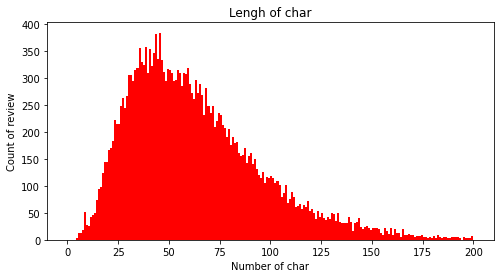

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=200, range=[0, 200], facecolor='r', label='char')
plt.title('Lengh of char')
plt.xlabel('Number of char')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(train_length):4d}")
print(f"char 길이 최소:    {np.min(train_length):4d}")
print(f"char 길이 평균:    {np.mean(train_length):7.2f}")
print(f"char 길이 표준편차: {np.std(train_length):7.2f}")

char 길이 최대:    1970
char 길이 최소:       4
char 길이 평균:      63.57
char 길이 표준편차:   37.59


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 25/100분위:    38.00
char 50/100분위:    57.00
char 75/100분위:    81.00
char IQR:          43.00
char MAX/100분위:  145.50


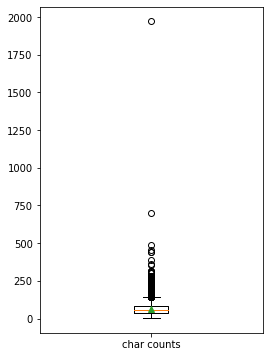

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
plt.show()

## word length

In [ ]:
# word 길이 데이터
train_length = df.iloc[:,0].apply(lambda x:len(x.split()))
train_length.head(10)

0    11
1    12
2    10
3    26
4    12
5    15
6    18
7     6
8     3
9    12
Name: text, dtype: int64

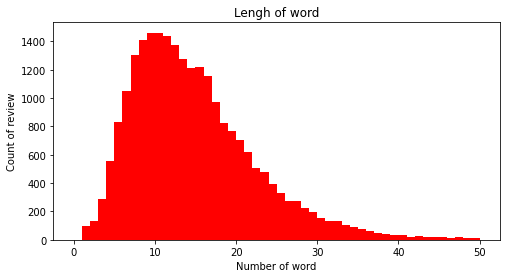

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=50, range=[0, 50], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(train_length):4d}")
print(f"word 길이 최소:    {np.min(train_length):4d}")
print(f"word 길이 평균:    {np.mean(train_length):7.2f}")
print(f"word 길이 표준편차: {np.std(train_length):7.2f}")

word 길이 최대:     344
word 길이 최소:       1
word 길이 평균:      14.43
word 길이 표준편차:    8.26


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 25/100분위:     9.00
word 50/100분위:    13.00
word 75/100분위:    18.00
word IQR:           9.00
word MAX/100분위:   31.50


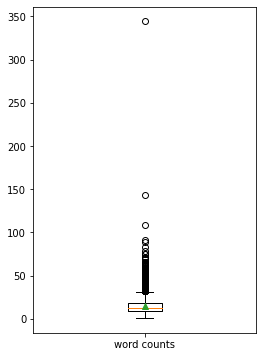

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['word counts'], showmeans=True)
plt.show()

## token length

In [ ]:
def get_tag_data(filepath):
    tags = []

    with open(filepath) as f:
      
        for line in f:
            line = line.strip()
            # print(line)
            if line.startswith('##'):
                pass

            else:
                tokens = line.split()
                # print(tokens)
                if len(tokens) == 4:
                    tags.append(tokens[3])
    return tags

In [ ]:
# for file in files:
#     with open(os.path.join('/content/NER/말뭉치 - 형태소_개체명', files[0])) as f:
#         for i ,line in enumerate(f):
#             line = line.strip() #strip안하면 개행문자가 되니까 2줄이 되지
#             print(line)
#             if i > 100:
#                 break


In [ ]:
label_counter = collections.defaultdict(int)

for file in files:
    tags = get_tag_data(os.path.join('/content/NER/말뭉치 - 형태소_개체명', file))
    for tag in tags:
        label_counter[tag] += 1

label_counter

defaultdict(int,
            {'B-DAT': 6689,
             'B-DUR': 1586,
             'B-LOC': 7873,
             'B-MNY': 1619,
             'B-NOH': 16227,
             'B-ORG': 17208,
             'B-PER': 18544,
             'B-PNT': 1905,
             'B-POH': 8387,
             'B-TIM': 483,
             'I-DAT': 8381,
             'I-DUR': 3424,
             'I-LOC': 4467,
             'I-MNY': 4308,
             'I-NOH': 18563,
             'I-ORG': 11721,
             'I-PER': 5946,
             'I-PNT': 1977,
             'I-POH': 18449,
             'I-TIM': 1716,
             'O': 887860})

In [ ]:
label_counter = sorted(label_counter.items(), key = lambda x : x[1])

for i in label_counter:
    print(i)
    # key = lambda x : x[1]

AttributeError: ignored

In [ ]:
# document 길이 데이터
train_length = df_train.iloc[:,0].apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

NameError: ignored

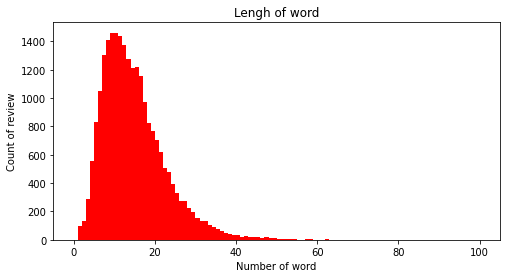

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=100, range=[0, 100], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     344
token 길이 최소:       1
token 길이 평균:      14.43
token 길이 표준편차:    8.26


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:     9.00
token 50/100분위:    13.00
token 75/100분위:    18.00
token IQR:           9.00
token MAX/100분위:   31.50


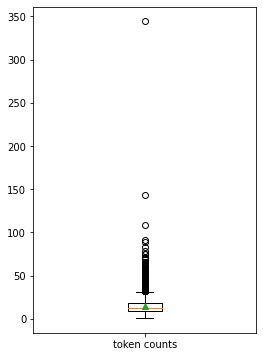

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['token counts'], showmeans=True)
plt.show()

## Label Count

In [ ]:
label_count = df_train['gold_label'].value_counts()
label_count

contradiction    311870
neutral          311847
entailment       311820
Name: gold_label, dtype: int64

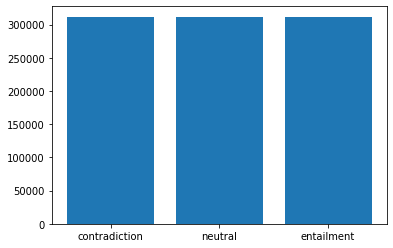

In [ ]:
plt.bar(["contradiction", "neutral", "entailment"], label_count)
plt.show()


# tra, test 데이터 생성

In [ ]:
len(df) 

23963

In [ ]:
n_train = int(len(df) * 0.8)
n_test = len(df) - n_train

len(df), n_train, n_test

(23963, 19170, 4793)

In [ ]:
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

df_train.shape, df_test.shape

((19170, 2), (4793, 2))

In [ ]:
df_train = df_train.sample(3)
df_test = df_test.sample(3)

In [ ]:
def arrange_pos(text):
    poses = okt.pos(text)
    # print(poses) # 아직까진 띄어쓰기에 대한 정보가 없지
    # print(text)
    index = 0
    pos_list = []
    for w, p in poses:
        # print(w,p, index)
        if text[index] == ' ':
            index += 1 # 이제야 공백처리가 됐네
        w_len = len(w)
        # print(text[index: index + w_len]) # 이게 text의 시작점 위치 저장
        # print()
        assert w == text[index:index + w_len] #혹시모를 방어 코드
        pos_list.append([w, p , 'O', index, index + w_len]) # (단어, 품사종류, label값의 자리를 만드는(일단 기본으로 넣고), 그단어의 시작점, 그단어의 끝점)
        index += w_len # 아직도 공백처리가 안되네
    return pos_list

In [ ]:
arrange_pos('용인 시민축구단 : 서울 파벌FC (용인종합운동장)')

[['용인', 'Noun', 'O', 0, 2],
 ['시민', 'Noun', 'O', 3, 5],
 ['축구단', 'Noun', 'O', 5, 8],
 [':', 'Punctuation', 'O', 9, 10],
 ['서울', 'Noun', 'O', 11, 13],
 ['파벌', 'Noun', 'O', 14, 16],
 ['FC', 'Alpha', 'O', 16, 18],
 ['(', 'Punctuation', 'O', 19, 20],
 ['용인', 'Noun', 'O', 20, 22],
 ['종합', 'Noun', 'O', 22, 24],
 ['운동장', 'Noun', 'O', 24, 27],
 [')', 'Punctuation', 'O', 27, 28]]

In [ ]:
def arrange_label(text, label):
    pattern = re.compile("<([^<]+):([A-Z]{3})>")
    matchs = pattern.finditer(label) # 이런 꺽새가 여러개 있으니까 finditer로 뽑아낼게

    n_match = 0
    label_list = []
    for match in matchs:

        w = match[1]
        t = match[2]
        s = match.start()
        e = match.end()
        # print(match)
        # print(w)
        # print(t)
        # print(s)
        # print(e)
        i1 = s - 6 * n_match  # 이게 시작점 (처음은0)# 한번 돌아갈때마다 <>:OPG 총 6개 들어가니까 6n으로 index자리를 빼겠다는거지
        i2 = e - 6 * n_match -6# 이거는 text의 마지막 index에서 -6해야지 위에 특별문자 6개 때문에
        # print( i1,i2)
        assert w == text[i1:i2]
        label_list.append([w,t,i1,i2])
        n_match += 1
    return label_list


In [ ]:
arrange_label('용인 시민축구단 : 서울 파발FC (용인종합운동장)', '<용인 시민축구단:ORG> : <서울 파발FC:ORG> (<용인종합운동장:LOC>)')

[['용인 시민축구단', 'ORG', 0, 8],
 ['서울 파발FC', 'ORG', 11, 18],
 ['용인종합운동장', 'LOC', 20, 27]]

In [ ]:
def arrange_data(text, label):
    pos_list = arrange_pos(text)
    label_list = arrange_label(text,label)
    # print(text)
    # print(label)

    for pos in pos_list:
        flag = False
        for label in label_list:
            if pos[3] < label[3] and pos[4] >label[2]: # text와 label의 시작점과 끝점을 비교!
                pos[2] = f'I-{label[1]}' if flag else f'B-{label[1]}' # 아까 label 자리를 만들어줬으니까 오른쪽과 비교해서 걸리는 족거는 label을 바꾸는 거지
                # print(flag,label,pos)  ## flag가 true면 왼쪽 아니면 오른쪽!
                flag = True
    return pos_list
            
    # print()

In [ ]:
def make_data(df,vocab_word, vocab_pos, vocab_tag, okt, n_seq):
    inputs_1, inputs_2,labels = [], [], []

    for i , row in tqdm(df_train.iterrows(), total = len(df_train)):
        input_1, input_2, label = [], [] ,[]
        pos_list = arrange_data(row['text'], row['label'])

        # print(pos_list)
        for pos in pos_list:
            input_1.append(vocab_word.get(pos[0],1))
            input_2.append(vocab_pos.get(pos[1],1))
            label.append(vocab_tag.get(pos[2],2))
        # print(input_1,input_2,label)

    input_1 = input_1[:n_seq]
    input_1 = input_1 + [0] * (n_seq - len(input_1))
    inputs_1.append(input_1)

    input_2 = input_2[:n_seq]
    input_2 = input_2 + [0] * (n_seq - len(input_2))
    inputs_2.append(input_2)

    label = label[:n_seq]
    label = label + [0] * (n_seq - len(label))
    labels.append(label)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)

    return inputs_1, inputs_2, labels

In [ ]:
# vocab_word
# vocab_pos.txt
# vocab_tag

In [ ]:
inputs_1 , inputs_2, labels = make_data(df_train, vocab_word, vocab_pos, vocab_tag, okt , 80)
inputs_1 , inputs_2, labels

(array([[  697,    53,  4284,    19, 44364, 44365,    58,  4223,    32,
          1861,  7264,    12,  6826,    37,  1006,  3711,   225,  3677,
            79,   809,   396,    53,  7899, 17596,  1216,  3958, 44366,
          3636,    37, 19195,   560,  1216,   112,   128,  1515,  6567,
           396,     7,   328,   328,  1716,   347, 19913,  4406,  1407,
         11471,    21,     7,   809,    14,   128, 44367,   740,   418,
         44368,    21,  9281,   546,    19, 44369, 44370,  1924,    79,
         19245,   187, 44371,   187,  2538,  2189, 44372,    21,  8873,
            56,    24, 11429, 44373, 44374,   108, 22935,   143]]),
 array([[ 3,  4,  3,  4,  6,  3,  4,  3,  4, 10,  3,  4,  3,  4,  3,  6,
          3,  4,  7,  3, 12,  4,  3,  3,  4,  3,  4,  3,  4,  6,  3,  4,
          3,  4,  6,  3, 12,  4,  3,  3,  3,  4,  3,  4, 10,  6,  7,  3,
          3,  3,  4,  3,  3,  4, 10,  7, 11,  3,  4,  3,  7,  3,  7,  3,
          7,  9,  7,  6,  6,  6,  7,  3,  4,  9,  3,  6,  3,  4,

In [ ]:
inputs_11 , inputs_22, labelss = make_data(df_test, vocab_word, vocab_pos, vocab_tag, okt , 80)
inputs_11 , inputs_22, labelss

(array([[  697,    53,  4284,    19, 44364, 44365,    58,  4223,    32,
          1861,  7264,    12,  6826,    37,  1006,  3711,   225,  3677,
            79,   809,   396,    53,  7899, 17596,  1216,  3958, 44366,
          3636,    37, 19195,   560,  1216,   112,   128,  1515,  6567,
           396,     7,   328,   328,  1716,   347, 19913,  4406,  1407,
         11471,    21,     7,   809,    14,   128, 44367,   740,   418,
         44368,    21,  9281,   546,    19, 44369, 44370,  1924,    79,
         19245,   187, 44371,   187,  2538,  2189, 44372,    21,  8873,
            56,    24, 11429, 44373, 44374,   108, 22935,   143]]),
 array([[ 3,  4,  3,  4,  6,  3,  4,  3,  4, 10,  3,  4,  3,  4,  3,  6,
          3,  4,  7,  3, 12,  4,  3,  3,  4,  3,  4,  3,  4,  6,  3,  4,
          3,  4,  6,  3, 12,  4,  3,  3,  3,  4,  3,  4, 10,  6,  7,  3,
          3,  3,  4,  3,  3,  4, 10,  7, 11,  3,  4,  3,  7,  3,  7,  3,
          7,  9,  7,  6,  6,  6,  7,  3,  4,  9,  3,  6,  3,  4,

In [ ]:
# inputs_1
# inputs_2
# label

In [ ]:
# 내가 하던중
# 이 단어가 어디의 위치에 있는지 알아냈지

import re

for i, row in df_train.iterrows():
    text = row['text']
    label = row['label']
    poses = okt.pos(text)

    print(text)
    print(poses)
    # print(label)

    index = 0
    data = []
    for w, p in poses:
        if text[index] == ' ':
            index += 1
        w_len = len(w)
        data.append([w,p,index, index + w_len])
        index += w_len
    print(data)

북한 6차 핵실험 임박?…사용 안 한 3번 갱도에 위장막 설치
[('북한', 'Noun'), ('6', 'Number'), ('차', 'Noun'), ('핵실험', 'Noun'), ('임박', 'Noun'), ('?…', 'Punctuation'), ('사용', 'Noun'), ('안', 'Noun'), ('한', 'Verb'), ('3', 'Number'), ('번', 'Noun'), ('갱도', 'Noun'), ('에', 'Josa'), ('위장', 'Noun'), ('막', 'Noun'), ('설치', 'Noun')]
[['북한', 'Noun', 0, 2], ['6', 'Number', 3, 4], ['차', 'Noun', 4, 5], ['핵실험', 'Noun', 6, 9], ['임박', 'Noun', 10, 12], ['?…', 'Punctuation', 12, 14], ['사용', 'Noun', 14, 16], ['안', 'Noun', 17, 18], ['한', 'Verb', 19, 20], ['3', 'Number', 21, 22], ['번', 'Noun', 22, 23], ['갱도', 'Noun', 24, 26], ['에', 'Josa', 26, 27], ['위장', 'Noun', 28, 30], ['막', 'Noun', 30, 31], ['설치', 'Noun', 32, 34]]
가격은 4만8000원(세금 및 봉사료 포함). 기간은 3월 28일까지다.
[('가격', 'Noun'), ('은', 'Josa'), ('4만', 'Number'), ('8000원', 'Number'), ('(', 'Punctuation'), ('세금', 'Noun'), ('및', 'Noun'), ('봉사', 'Noun'), ('료', 'Noun'), ('포함', 'Noun'), (').', 'Punctuation'), ('기간', 'Noun'), ('은', 'Josa'), ('3월', 'Number'), ('28일', 'Number'), ('까지다', 'Foreign'), 

In [ ]:
# 이 단어가 어디의 위치에 있는지 알아냈지

import re

for i, row in df_train.iterrows():
    text = row['text']
    label = row['label']
    poses = okt.pos(text)

    print(text)
    # print(poses)
    print(label)

    index = 0
    data = []
    for w, p in poses:
        # print(w,p)
        if text[index] == ' ': # 띄어쓰기 조심해주고
            index += 1
        w_len = len(w)
        # print(w, ':', text[index:index + w_len])
        assert w == text[index:index + w_len]
        data.append([w,p, index, index + w_len])
        index += w_len
    # print(data)
    pattern = re.compile("<([^<]+):([A-Z]{3})>")
    matchs = pattern.finditer(label)

    n_match = 0
    for match in matchs:
        # print(match)
        # print(match[1])
        # print(match[2])
        # print(match.start())
        # print(match.end())

        w = match[1]
        t = match[2]
        s = match.start()
        e = match.end()
        i1 = s - 6 * n_match
        i2 = e - 6 * n_match -6
        assert w == text[i1:i2]
        n_match += 1

        print()
        print(w,t,s,e)
        print(label[s:e]) # label의 위치를 뽑았지? -> 이제 text에서 뽑아볼게?

북한 6차 핵실험 임박?…사용 안 한 3번 갱도에 위장막 설치
<북한:ORG> <6차:NOH> 핵실험 임박?…사용 안 한 <3번:NOH> 갱도에 위장막 설치

북한 ORG 0 8
<북한:ORG>

6차 NOH 9 17
<6차:NOH>

3번 NOH 33 41
<3번:NOH>
가격은 4만8000원(세금 및 봉사료 포함). 기간은 3월 28일까지다.
가격은 <4만8000원:MNY>(세금 및 봉사료 포함). 기간은 <3월 28일:DAT>까지다.

4만8000원 MNY 4 17
<4만8000원:MNY>

3월 28일 DAT 36 48
<3월 28일:DAT>
"개성 넘치는 숙박시설·음식점 제주 매력 느끼는 박물관·체험장 전망 좋은 맛집·카페 곳곳에"우리나라에서 가장 큰 보물섬 제주도. 예로부터 돌·바람·여자가 많고, 도둑·대문·거지가 없다고 해서 육지와는 다른 독창적인 문화를 지졌다.
"개성 넘치는 숙박시설·음식점 <제주:LOC> 매력 느끼는 박물관·체험장 전망 좋은 맛집·카페 곳곳에"우리나라에서 가장 큰 보물섬 <제주도:LOC>. 예로부터 돌·바람·여자가 많고, 도둑·대문·거지가 없다고 해서 육지와는 다른 독창적인 문화를 지졌다.

제주 LOC 17 25
<제주:LOC>

제주도 LOC 73 82
<제주도:LOC>



# modeling

In [ ]:
args.n_vocab_word = len(vocab_word)
args.n_vocab_pos = len(vocab_pos)
args.d_model = 4
args.n_out = len(vocab_tag)
args

Namespace(d_model=4, n_out=23, n_vocab_pos=24, n_vocab_word=49943, seed=1234)

In [ ]:
inputs_1 = np.random.randint(0,10, (1,8))
inputs_2 = np.random.randint(0,10 ,(1,8))
labels= np.random.randint(0,10, (1,8))

inputs_1, inputs_2, labels

(array([[5, 1, 5, 3, 3, 9, 2, 3]]),
 array([[3, 0, 4, 2, 8, 1, 7, 0]]),
 array([[3, 2, 2, 0, 2, 0, 7, 9]]))

In [ ]:
embed_word = tf.keras.layers.Embedding(args.n_vocab_word, args.d_model)
embed_pos = tf.keras.layers.Embedding(args.n_vocab_pos, args.d_model)

In [ ]:
hidden_word = embed_word(inputs_1) # 단어
hidden_pos = embed_pos(inputs_2) # 형태소

hidden_word, hidden_pos

(<tf.Tensor: shape=(1, 8, 4), dtype=float32, numpy=
 array([[[-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
         [-0.00696643,  0.04061912,  0.00072207, -0.01411822],
         [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
         [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
         [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
         [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
         [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
         [ 0.00873896, -0.04772998, -0.00643448,  0.04782395]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 8, 4), dtype=float32, numpy=
 array([[[-0.02956598,  0.03029363,  0.0141835 ,  0.04274947],
         [-0.01746353, -0.03612994,  0.01480493, -0.01959816],
         [ 0.00848954,  0.0289362 ,  0.02202288, -0.01791685],
         [-0.01098528,  0.0306937 , -0.00226969,  0.00098121],
         [ 0.03756353,  0.00737777,  0.0342937 ,  0.00782709],
         [-0.01632367, -0.03698195,  0.02057973,  0.

In [ ]:
hidden =  hidden_word + hidden_pos # transformer의 방법
hidden

<tf.Tensor: shape=(1, 8, 4), dtype=float32, numpy=
array([[[-0.05755295,  0.02919292,  0.0274959 ,  0.04912318],
        [-0.02442996,  0.00448918,  0.01552701, -0.03371638],
        [-0.01949743,  0.02783549,  0.03533528, -0.01154313],
        [-0.00224632, -0.01703628, -0.00870416,  0.04880517],
        [ 0.04630249, -0.04035221,  0.02785922,  0.05565105],
        [-0.02888414, -0.00264835, -0.00537778,  0.05407178],
        [-0.0014594 ,  0.04232673,  0.03342761,  0.02413317],
        [-0.00872457, -0.08385992,  0.00837046,  0.02822579]]],
      dtype=float32)>

In [ ]:
hidden = tf.concat([hidden_word, hidden_pos] ,axis = -1) #  concatenate 의 방법
hidden

<tf.Tensor: shape=(1, 8, 8), dtype=float32, numpy=
array([[[-0.01826397, -0.03069841,  0.03251565,  0.00923193,
         -0.02606037, -0.04369395, -0.00189743, -0.02968305],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716,
          0.00848954,  0.0289362 ,  0.02202288, -0.01791685],
        [-0.00696643,  0.04061912,  0.00072207, -0.01411822,
          0.04709952,  0.03384167,  0.0277797 ,  0.04307822],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371,
         -0.02956598,  0.03029363,  0.0141835 ,  0.04274947],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ,
          0.04709952,  0.03384167,  0.0277797 ,  0.04307822],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395,
          0.03756353,  0.00737777,  0.0342937 ,  0.00782709],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213,
          0.03824272, -0.00190289, -0.01223388, -0.045441  ],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716,
         -0.02606037, -0.04

In [ ]:
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 3, return_sequences = True))
hidden = lstm(hidden)
hidden

# 한 라인의 앞 3개는  forward, 연속으로 뒤 3개는 backwoard

<tf.Tensor: shape=(1, 8, 6), dtype=float32, numpy=
array([[[ 0.01119458,  0.00386365, -0.01900268, -0.0200532 ,
          0.01412361,  0.01295322],
        [ 0.00663345,  0.00144801, -0.01329303, -0.00523397,
          0.0070113 ,  0.00516357],
        [ 0.01052282, -0.00425318, -0.0141709 , -0.01085733,
          0.00346468,  0.00995352],
        [ 0.01261455, -0.0004417 , -0.01541479, -0.00843041,
         -0.00680656,  0.01314576],
        [ 0.02109461, -0.00906169, -0.0098762 , -0.00609809,
         -0.0044841 ,  0.01417515],
        [ 0.02149547, -0.00205709, -0.01698249, -0.01367218,
          0.00132788,  0.01122548],
        [ 0.02782848, -0.01057183, -0.01961453, -0.00656649,
          0.00165898,  0.00795364],
        [ 0.0212374 , -0.0047496 , -0.0106509 ,  0.00730262,
         -0.00875642,  0.0056292 ]]], dtype=float32)>

In [ ]:
linear = tf.keras.layers.Dense(args.n_out, activation = tf.nn.softmax)
y_pred = linear(hidden)
y_pred

<tf.Tensor: shape=(1, 8, 23), dtype=float32, numpy=
array([[[0.04395939, 0.04344675, 0.04371439, 0.042808  , 0.043603  ,
         0.04300277, 0.04359424, 0.04345811, 0.04357734, 0.04300072,
         0.04407805, 0.04331717, 0.04336938, 0.0428451 , 0.04329093,
         0.04432363, 0.04404587, 0.04355692, 0.04343066, 0.04270465,
         0.04340398, 0.04370025, 0.04376869],
        [0.04379249, 0.04347576, 0.04349188, 0.04318433, 0.04365001,
         0.04323081, 0.04350236, 0.04355814, 0.04339131, 0.04316129,
         0.04377589, 0.04334446, 0.04333544, 0.04316236, 0.04333924,
         0.04385624, 0.04372881, 0.04352093, 0.04357167, 0.04307847,
         0.04339673, 0.04373412, 0.04371728],
        [0.04388374, 0.04328251, 0.04355641, 0.04307757, 0.04345727,
         0.04308127, 0.04357451, 0.04364635, 0.04338774, 0.04324247,
         0.0438393 , 0.04336772, 0.04345888, 0.04322118, 0.0435493 ,
         0.04409183, 0.04375797, 0.04354826, 0.04327986, 0.04300493,
         0.04322601, 0.04375

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
loss = loss_fn(labels, y_pred)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=3.1341743>

# all data

In [ ]:
args.n_vocab_word = len(vocab_word)
args.n_vocab_pos = len(vocab_pos)
args.d_model = 256
args.n_out = len(vocab_tag)
args

Namespace(d_model=256, n_out=23, n_vocab_pos=24, n_vocab_word=49943, seed=1234)

In [ ]:
def build_model(args):
    inputs_word = tf.keras.layers.Input((None,), name = 'inputs_word')
    inputs_pos = tf.keras.layers.Input((None,), name = 'inputs_pos')

    embed_word = tf.keras.layers.Embedding(args.n_vocab_word, args.d_model, name = 'embed_word')
    hidden_word = embed_word(inputs_word)

    embed_pos = tf.keras.layers.Embedding(args.n_vocab_word, args.d_model, name = 'embed_pos')
    hidden_pos = embed_pos(inputs_pos)

    concat_hidden = tf.concat([hidden_word, hidden_pos], axis = -1)
    
    bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = args.d_model, return_sequences = True, return_state= True), name = 'bi-lstm')
    hidden, fw_h,fw_c, bw_h,bw_c = bilstm_1(concat_hidden)

    bilstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = args.d_model, return_sequences = True),name = 'bi-lstm2')
    hidden =     bilstm_2(hidden, initial_state = (fw_h, fw_c, bw_h,bw_c))

    linear = tf.keras.layers.Dense(args.n_out, activation = tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs = (inputs_word, inputs_pos), outputs = y_pred)
    return model

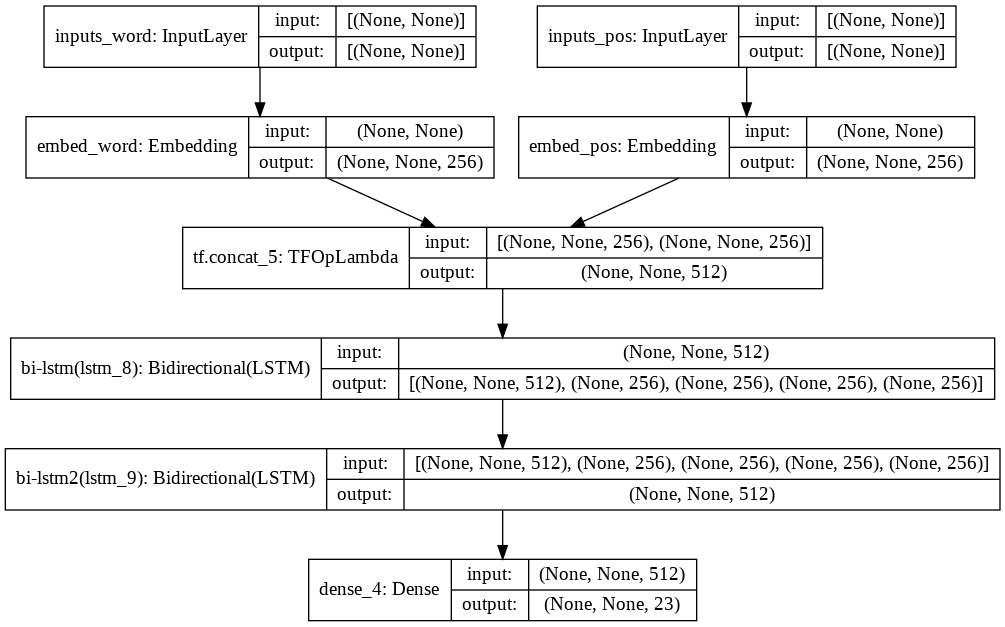

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes = True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit((inputs_1, inputs_2),labels,
                    epochs = 10,
                    batch_size = 256,
                    validation_data =((inputs_11,inputs_22), labelss))

Epoch 1/10
1/1 [==============================] - 14s 14s/step - loss: 3.1512 - accuracy: 0.0000e+00 - val_loss: 2.8634 - val_accuracy: 0.9750
Epoch 2/10
1/1 [==============================] - 0s 454ms/step - loss: 2.8634 - accuracy: 0.9750 - val_loss: 2.3009 - val_accuracy: 0.9750
Epoch 3/10
1/1 [==============================] - 0s 286ms/step - loss: 2.3009 - accuracy: 0.9750 - val_loss: 0.8695 - val_accuracy: 0.9750
Epoch 4/10
1/1 [==============================] - 0s 286ms/step - loss: 0.8695 - accuracy: 0.9750 - val_loss: 0.2010 - val_accuracy: 0.9750
Epoch 5/10
1/1 [==============================] - 0s 293ms/step - loss: 0.2010 - accuracy: 0.9750 - val_loss: 0.2607 - val_accuracy: 0.9750
Epoch 6/10
1/1 [==============================] - 0s 297ms/step - loss: 0.2607 - accuracy: 0.9750 - val_loss: 0.2643 - val_accuracy: 0.9750
Epoch 7/10
1/1 [==============================] - 0s 286ms/step - loss: 0.2643 - accuracy: 0.9750 - val_loss: 0.2371 - val_accuracy: 0.9750
Epoch 8/10
1/1 [=

In [ ]:
def do_predict(model, text):
    poses = okt.pos(text)
    input_word, input_pos = [], []
    for pos in poses:
        input_word.append(vocab_word.get(pos[0],1))
        inputs_pos.append(vocab_pos.get(pos[1],1))
    inputs_word = np.array([input_word])
    inputs_pos = np.array([input_pos])

    y_pred = model.predict((inputs_word, inputs_pos))
    print(y_pred.shape) # (bs, 6)
    y_class = np.argmax(y_pred, axis = -1)[0]
    print(y_class.shape)

    result = []
    for pos, _id in zip(poses, y_class):
        result.append((pos[0], id_to_label[_id]))
    return result

# Loss & Acc*

# Small Data Project

- PAD:  # PAD
- O:  # other
- B_DAT  # 날짜
- I_DAT
- B_DUR  # 기간
- I_DUR
- B_LOC  # 위치
- I_LOC
- B_MNY  # 통화
- I_MNY
- B_NOH  # 수량
- I_NOH
- B_ORG  # 기관
- I_ORG
- B_PER  # 사람
- I_PER
- B_PNT  # 비율
- I_PNT
- B_POH  # 기타
- I_POH
- B_TIM  # 시간
- I_TIM

## Train, Test 데이터 생성

## Modeling

## Train

## 평가

## 배포